# Entrenando con VAE

Finalmente, la hora de la verdad!! toca entrenar a la red y ver cómo funciona. Para esto voy a utilizar VAE, un tipo de autoencoder que en su latent space tiene funciones de campana de Gauss, es decir, a cada punto le agrego una simetría a partir de agregarle una media y una desviación estándar

# Definición del autoencoder:

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import os
import pickle
import glob
import soundfile as sf
import librosa

from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
    Flatten, Dense, Reshape, Conv2DTranspose, Activation, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import tensorflow as tf


tf.compat.v1.disable_eager_execution()

In [4]:
class VAE:
    
    #VAE represents a Deep Convolutional variational autoencoder architecture
    #with mirrored encoder and decoder components.

    def __init__(self,
                 input_shape,
                 conv_filters,
                 conv_kernels,
                 conv_strides,
                 latent_space_dim):
        self.input_shape = input_shape # [28, 28, 1]
        self.conv_filters = conv_filters # [2, 4, 8]
        self.conv_kernels = conv_kernels # [3, 5, 3]
        self.conv_strides = conv_strides # [1, 2, 2]
        self.latent_space_dim = latent_space_dim # 2
        self.reconstruction_loss_weight = 1000000

        self.encoder = None
        self.decoder = None
        self.model = None

        self._num_conv_layers = len(conv_filters)
        self._shape_before_bottleneck = None
        self._model_input = None

        self._build()

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()
        self.model.summary()

    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[self._calculate_reconstruction_loss,
                                    self._calculate_kl_loss])

    def train(self, x_train, y_train, batch_size, num_epochs):
        self.model.fit(x_train,
                       y_train,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       shuffle=True)

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.model.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        autoencoder = VAE(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        autoencoder.load_weights(weights_path)
        return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        reconstruction_loss = self._calculate_reconstruction_loss(y_target, y_predicted)
        kl_loss = self._calculate_kl_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss
        return combined_loss

    def _calculate_reconstruction_loss(self, y_target, y_predicted):
        error = y_target - y_predicted
        reconstruction_loss = K.mean(K.square(error), axis=[1, 2, 3])
        return reconstruction_loss

    def _calculate_kl_loss(self, y_target, y_predicted):
        kl_loss = -0.5 * K.sum(1 + self.log_variance - K.square(self.mu) -
                               K.exp(self.log_variance), axis=1)
        return kl_loss

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.input_shape,
            self.conv_filters,
            self.conv_kernels,
            self.conv_strides,
            self.latent_space_dim
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.model.save_weights(save_path)

    def _build(self):
        self._build_encoder()
        self._build_decoder()
        self._build_autoencoder()

    def _build_autoencoder(self):
        model_input = self._model_input
        model_output = self.decoder(self.encoder(model_input))
        self.model = Model(model_input, model_output, name="autoencoder")

    def _build_decoder(self):
        decoder_input = self._add_decoder_input()
        dense_layer = self._add_dense_layer(decoder_input)
        reshape_layer = self._add_reshape_layer(dense_layer)
        conv_transpose_layers = self._add_conv_transpose_layers(reshape_layer)
        decoder_output = self._add_decoder_output(conv_transpose_layers)
        self.decoder = Model(decoder_input, decoder_output, name="decoder")

    def _add_decoder_input(self):
        return Input(shape=self.latent_space_dim, name="decoder_input")

    def _add_dense_layer(self, decoder_input):
        num_neurons = np.prod(self._shape_before_bottleneck) # [1, 2, 4] -> 8
        dense_layer = Dense(num_neurons, name="decoder_dense")(decoder_input)
        return dense_layer

    def _add_reshape_layer(self, dense_layer):
        return Reshape(self._shape_before_bottleneck)(dense_layer)

    def _add_conv_transpose_layers(self, x):
        ###Add conv transpose blocks.###

        # loop through all the conv layers in reverse order and stop at the
        # first layer
        for layer_index in reversed(range(1, self._num_conv_layers)):
            x = self._add_conv_transpose_layer(layer_index, x)
        return x

    def _add_conv_transpose_layer(self, layer_index, x):
        layer_num = self._num_conv_layers - layer_index
        conv_transpose_layer = Conv2DTranspose(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"decoder_conv_transpose_layer_{layer_num}"
        )
        x = conv_transpose_layer(x)
        x = ReLU(name=f"decoder_relu_{layer_num}")(x)
        x = BatchNormalization(name=f"decoder_bn_{layer_num}")(x)
        return x

    def _add_decoder_output(self, x):
        conv_transpose_layer = Conv2DTranspose(
            filters=1,
            kernel_size=self.conv_kernels[0],
            strides=self.conv_strides[0],
            padding="same",
            name=f"decoder_conv_transpose_layer_{self._num_conv_layers}"
        )
        x = conv_transpose_layer(x)
        output_layer = Activation("sigmoid", name="sigmoid_layer")(x)
        return output_layer

    def _build_encoder(self):
        encoder_input = self._add_encoder_input()
        conv_layers = self._add_conv_layers(encoder_input)
        bottleneck = self._add_bottleneck(conv_layers)
        self._model_input = encoder_input
        self.encoder = Model(encoder_input, bottleneck, name="encoder")

    def _add_encoder_input(self):
        return Input(shape=self.input_shape, name="encoder_input")

    def _add_conv_layers(self, encoder_input):
        ###Create all convolutional blocks in encoder.###
        x = encoder_input
        for layer_index in range(self._num_conv_layers):
            x = self._add_conv_layer(layer_index, x)
        return x

    def _add_conv_layer(self, layer_index, x):
        ###Add a convolutional block to a graph of layers, consisting of
        ###conv 2d + ReLU + batch normalization.
        
        layer_number = layer_index + 1
        conv_layer = Conv2D(
            filters=self.conv_filters[layer_index],
            kernel_size=self.conv_kernels[layer_index],
            strides=self.conv_strides[layer_index],
            padding="same",
            name=f"encoder_conv_layer_{layer_number}"
        )
        x = conv_layer(x)
        x = ReLU(name=f"encoder_relu_{layer_number}")(x)
        x = BatchNormalization(name=f"encoder_bn_{layer_number}")(x)
        return x

    def _add_bottleneck(self, x):
        ###Flatten data and add bottleneck with Guassian sampling (Dense
        ###layer).
        
        self._shape_before_bottleneck = K.int_shape(x)[1:]
        x = Flatten()(x)
        self.mu = Dense(self.latent_space_dim, name="mu")(x)
        self.log_variance = Dense(self.latent_space_dim,
                                  name="log_variance")(x)

        def sample_point_from_normal_distribution(args):
            mu, log_variance = args
            epsilon = K.random_normal(shape=K.shape(self.mu), mean=0.,
                                      stddev=1.)
            sampled_point = mu + K.exp(log_variance / 2) * epsilon
            return sampled_point

        x = Lambda(sample_point_from_normal_distribution,
                   name="encoder_output")([self.mu, self.log_variance])
        return x

In [5]:
#Veo cómo se armó el modelo

autoencoder = VAE(
    input_shape=(256, 256, 1),
    conv_filters=(512, 256, 128, 64, 32),
    conv_kernels=([3,5], [3,5], [3,5], [3,5], [3,5]),
    conv_strides=(2, 2, 2, 2, (2, 1)),
    latent_space_dim=128
)
autoencoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 128, 128, 512 8192        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 128, 128, 512 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 128, 128, 512 2048        encoder_relu_1[0][0]             
____________________________________________________________________________________________

# Entrenando a la bestia

Ahora toca probar si esta red funciona! Para esto tengo que traer los datos primero.

In [6]:
#Cargo las stft con ruido que voy a usar para entrenar.
os.chdir(r'C:\Users\maxia\Desktop\Facultad\Labo de acústica\Codigo')

X_train = np.load('audios_noise_train_Drive.npy')

#Info de los audios
print(len(X_train))
print(X_train[0])
print(X_train[-1])


8351
80\common_voice_es_21917140_3_SNR-15.npy
0\common_voice_es_18350128_1_SNR-0.npy


In [8]:
#Cargo los audios limpios que voy a usar para entrenar. 
os.chdir(r'C:\Users\maxia\Desktop\Facultad\Labo de acústica\Codigo')

y_train = np.load('audios_clean_train_Drive.npy')

#Info de los audios
print(len(y_train))
print(y_train[0])
print(y_train[-1])

8351
80\common_voice_es_21917140_3.npy
0\common_voice_es_18350128_1.npy


Inicio con el entrenamiento

In [10]:
#Funciones para entrenar

def load_fsdd(path, files):
    audios = []
    for file_name in files:
        spectrogram = np.load(path + file_name) # (n_bins, n_frames, 1)
        audios.append(spectrogram)
    audios = np.array(audios)
    audios = audios[..., np.newaxis] # -> (N°Audios, 256, 256, 1)
    return audios


def train(X_train, y_train, learning_rate, batch_size, epochs):
    autoencoder = VAE(
        input_shape=(256, 256, 1),
        conv_filters=(512, 256, 128, 64, 32),
        conv_kernels=([3,5], [3,5], [3,5], [3,5], [3,5]),
        conv_strides=(2, 2, 2, 2, (2, 1)),
        latent_space_dim=128
    )
    autoencoder.summary()
    autoencoder.compile(learning_rate)
    autoencoder.train(X_train, y_train, batch_size, epochs)
    return autoencoder

In [12]:
#Cargo los audios
print('Cargando audios...')

os.chdir(r'C:\Users\maxia\Desktop\Facultad\Labo de acústica\Codigo\Drive')
dir = os.getcwd()

SPECTROGRAMS_NOISE = dir + "\stft_ruido_train\\"
SPECTROGRAMS_CLEAN = dir + "\stft_train\\"

X_train = load_fsdd(SPECTROGRAMS_NOISE ,X_train)
y_train = load_fsdd(SPECTROGRAMS_CLEAN ,y_train)

print(f'Se cargaron {len(X_train)} espectrogramas de X_train')
print(f'Se cargaron {len(y_train)} espectrogramas de y_train')
print('Audios cargados!!! A entrenar mi rey')

Cargando audios...


KeyboardInterrupt: 

In [ ]:
!nvidia-smi

Wed Jun  2 19:59:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Entreno!!!
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive')

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
EPOCHS = 20

autoencoder = train(X_train, y_train, LEARNING_RATE, BATCH_SIZE, EPOCHS)
autoencoder.save("model_20-epocas_8351-audios_reconstruction_loss_weight-1000000")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
encoder_conv_layer_1 (Conv2D)   (None, 128, 128, 512 5120        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_relu_1 (ReLU)           (None, 128, 128, 512 0           encoder_conv_layer_1[0][0]       
__________________________________________________________________________________________________
encoder_bn_1 (BatchNormalizatio (None, 128, 128, 512 2048        encoder_relu_1[0][0]             
____________________________________________________________________________________________

#Creando audios a partir de la red

In [5]:
#Funciones para normalizar y desnormalizar

class MinMaxNormaliser:
    """MinMaxNormaliser applies min max normalisation to an array."""

    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def normalise(self, array):
        norm_array = (array - array.min()) / (array.max() - array.min())
        norm_array = norm_array * (self.max - self.min) + self.min
        return norm_array

    def denormalise(self, norm_array, original_min, original_max):
        array = (norm_array - self.min) / (self.max - self.min)
        array = array * (original_max - original_min) + original_min
        return array

In [6]:
class SoundGenerator:
    ###SoundGenerator is responsible for generating audios from
    #spectrograms.
    

    def __init__(self, vae, hop_length):
        self.vae = vae
        self.hop_length = hop_length
        self._min_max_normaliser = MinMaxNormaliser(0, 1)

    def generate(self, spectrograms, min_max_values):
        generated_spectrograms, latent_representations = \
            self.vae.reconstruct(spectrograms)
        signals = self.convert_spectrograms_to_audio(generated_spectrograms, min_max_values)
        return signals, latent_representations

    def convert_spectrograms_to_audio(self, spectrograms, min_max_values):
        signals = []
        for spectrogram, min_max_value in zip(spectrograms, min_max_values):
            # reshape the log spectrogram
            log_spectrogram = spectrogram[:, :, 0]
            # apply denormalisation
            denorm_log_spec = self._min_max_normaliser.denormalise(
                log_spectrogram, min_max_value["min"], min_max_value["max"])
            # log spectrogram -> spectrogram
            spec = librosa.db_to_amplitude(denorm_log_spec)
            # apply Griffin-Lim
            signal = librosa.griffinlim(S=spec, hop_length=self.hop_length)
            # append signal to "signals"
            signals.append(signal)
        return signals

In [8]:
def load_fsdd(spectrograms_path):
    x_train = []
    file_paths = []
    for root, _, file_names in os.walk(spectrograms_path):
        for file_name in file_names:
            file_path = os.path.join(root, file_name)
            spectrogram = np.load(file_path) # (n_bins, n_frames, 1)
            x_train.append(spectrogram)
            file_paths.append(file_path)
    x_train = np.array(x_train)
    x_train = x_train[..., np.newaxis] # -> (3000, 256, 64, 1)
    return x_train, file_paths


def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=2):
    
    file_paths_min_max = []
    for file in file_paths:
      file_paths_min_max.append('/Users/maxia/Desktop/Facultad/Labo de acústica/Codigo/10_stft_ruido_test/'+file.split('/')[-1])

    sampled_indexes = np.random.choice(range(len(spectrograms)), num_spectrograms)
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    name_of_audios = file_paths[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in file_paths_min_max]
    print(file_paths)
    print(sampled_min_max_values)
    return sampled_spectrogrmas, sampled_min_max_values, name_of_audios


def save_signals(signals, save_dir, name_of_audios, sample_rate=22050):
  for i, signal in enumerate(signals):
    signal = signal/max(signal)
    save_path = os.path.join(save_dir, name_of_audios[i].split('/')[-1] + ".wav")
    sf.write(save_path, signal, sample_rate)



In [ ]:
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive')
HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "samples/original/"
SAVE_DIR_GENERATED = "samples/generated/"
MIN_MAX_VALUES_PATH_clean = "/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/min_max_values_test.pkl"
MIN_MAX_VALUES_PATH_noise = "/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/min_max_values_ruido_test.pkl"


dir = os.getcwd()

SPECTROGRAMS_NOISE = dir + "/stft_ruido_test/"
SPECTROGRAMS_CLEAN = dir + "/stft_test/"

#X_train = load_fsdd(SPECTROGRAMS_NOISE ,X_train)
#y_train = load_fsdd(SPECTROGRAMS_CLEAN ,y_train)

# initialise sound generator
vae = VAE.load("model_20-epocas_8351-audios_reconstruction_loss_weight-1000000")
sound_generator = SoundGenerator(vae, HOP_LENGTH)

# load spectrograms + min max values
with open(MIN_MAX_VALUES_PATH_noise, "rb") as f:
    min_max_values_noise = pickle.load(f)

specs_noise, file_paths_noise = load_fsdd(SPECTROGRAMS_NOISE)

#print(specs_noise[0])
print(file_paths_noise[0].split('/')[-1])

common_voice_es_18485808_SNR-0.npy


In [ ]:
with open(MIN_MAX_VALUES_PATH_noise, "rb") as f:
    min_max_values_noise = pickle.load(f)
#print(f)
keys = []
for key in min_max_values_noise.keys():
  keys.append(key)
print(keys[0])

/Users/maxia/Desktop/Facultad/Labo de acústica/Codigo/10_stft_ruido_test/common_voice_es_18309707_SNR-0.npy


In [ ]:
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive')
HOP_LENGTH = 256
SAVE_DIR_ORIGINAL = "samples/original/"
SAVE_DIR_GENERATED = "samples/generated/"
MIN_MAX_VALUES_PATH_clean = "/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/min_max_values_test.pkl"
MIN_MAX_VALUES_PATH_noise = "/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/min_max_values_ruido_test.pkl"


dir = os.getcwd()

SPECTROGRAMS_NOISE = dir + "/stft_ruido_test/"
SPECTROGRAMS_CLEAN = dir + "/stft_test/"

#X_train = load_fsdd(SPECTROGRAMS_NOISE ,X_train)
#y_train = load_fsdd(SPECTROGRAMS_CLEAN ,y_train)

# initialise sound generator
vae = VAE.load("model_20-epocas_8351-audios_reconstruction_loss_weight-1000000")
sound_generator = SoundGenerator(vae, HOP_LENGTH)

# load spectrograms + min max values
with open(MIN_MAX_VALUES_PATH_noise, "rb") as f:
    min_max_values_noise = pickle.load(f)

specs_noise, file_paths_noise = load_fsdd(SPECTROGRAMS_NOISE)

# sample spectrograms + min max values
sampled_specs, sampled_min_max_values, name_of_audios = select_spectrograms(specs_noise, file_paths_noise, min_max_values_noise, num_spectrograms=30)

# generate audio for sampled spectrograms
signals, _ = sound_generator.generate(sampled_specs,
                                      sampled_min_max_values)

# convert spectrogram samples to audio
original_signals = sound_generator.convert_spectrograms_to_audio(sampled_specs, sampled_min_max_values)

# save audio signals
save_signals(signals, SAVE_DIR_GENERATED, name_of_audios)
save_signals(original_signals, SAVE_DIR_ORIGINAL, name_of_audios)

#Ploteo espectrogramas

Veo cómo salieron los espectros de los audios originales y los generados

In [ ]:
import librosa as lb
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

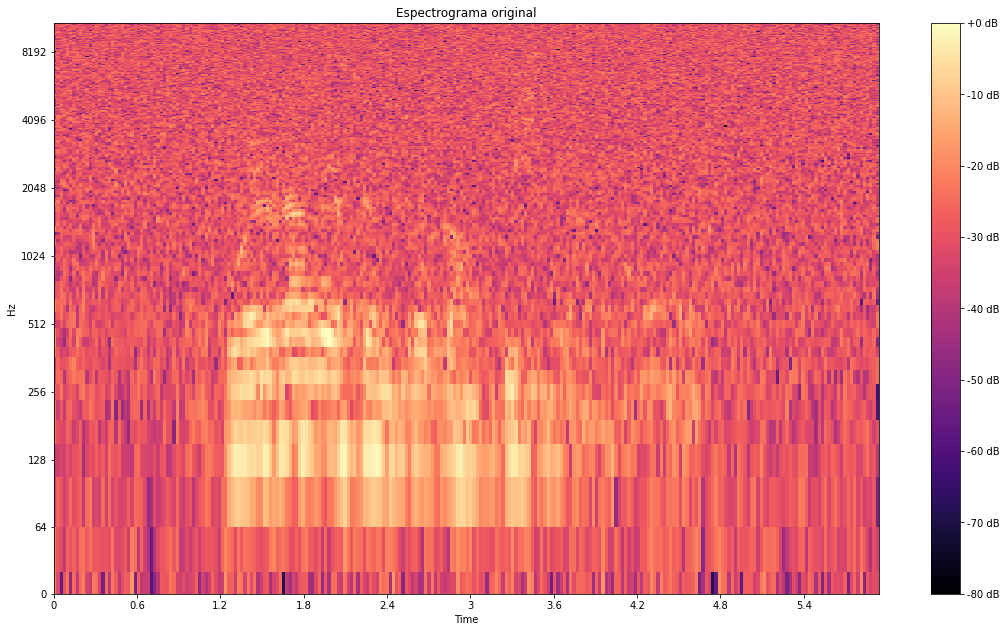

In [ ]:
#Espectro original amplitud
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/samples/original')
original, sr = lb.load('28.wav', sr=22050)

S_original = np.abs(lb.stft(original, n_fft=512, hop_length=256))

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
img = librosa.display.specshow(lb.amplitude_to_db(S_original,ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma original')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

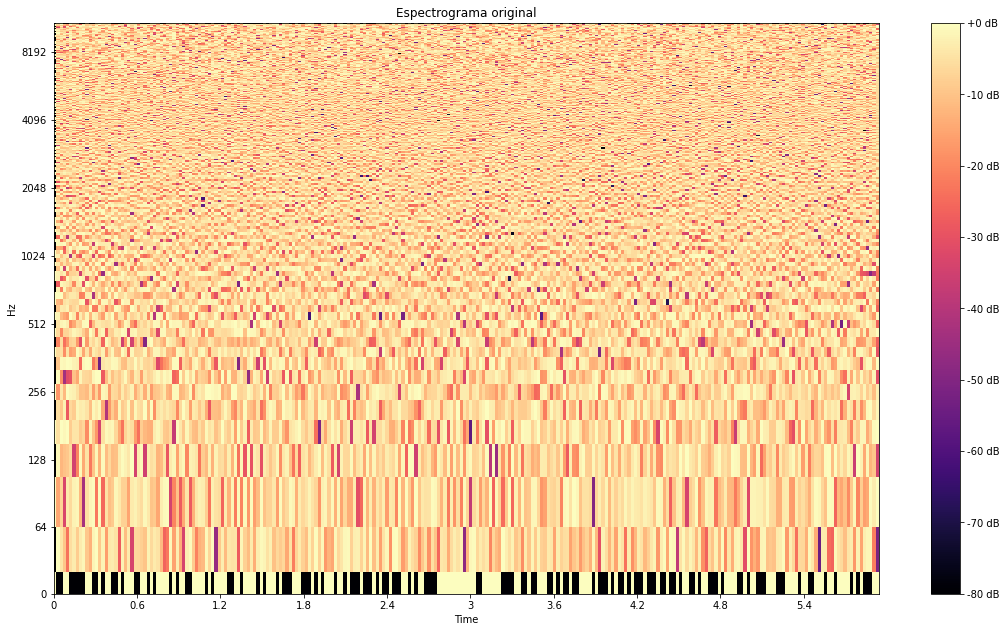

In [ ]:
#Espectro original fase
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/samples/original')
original, sr = lb.load('28.wav', sr=22050)

S_original = np.angle(lb.stft(original, n_fft=512, hop_length=256))

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
img = librosa.display.specshow(lb.amplitude_to_db(S_original,ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma original')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

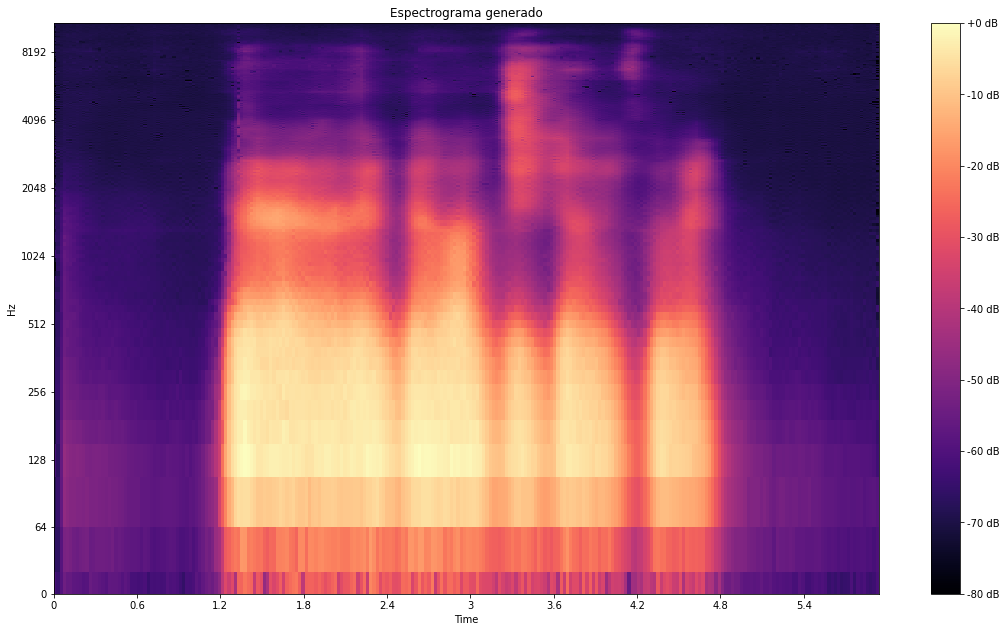

In [ ]:
#Espectro generado amplitud
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/samples/generated')
original, sr = lb.load('28.wav', sr=22050)

S_original = np.abs(lb.stft(original, n_fft=512, hop_length=256))

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
img = librosa.display.specshow(lb.amplitude_to_db(S_original,ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma generado')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

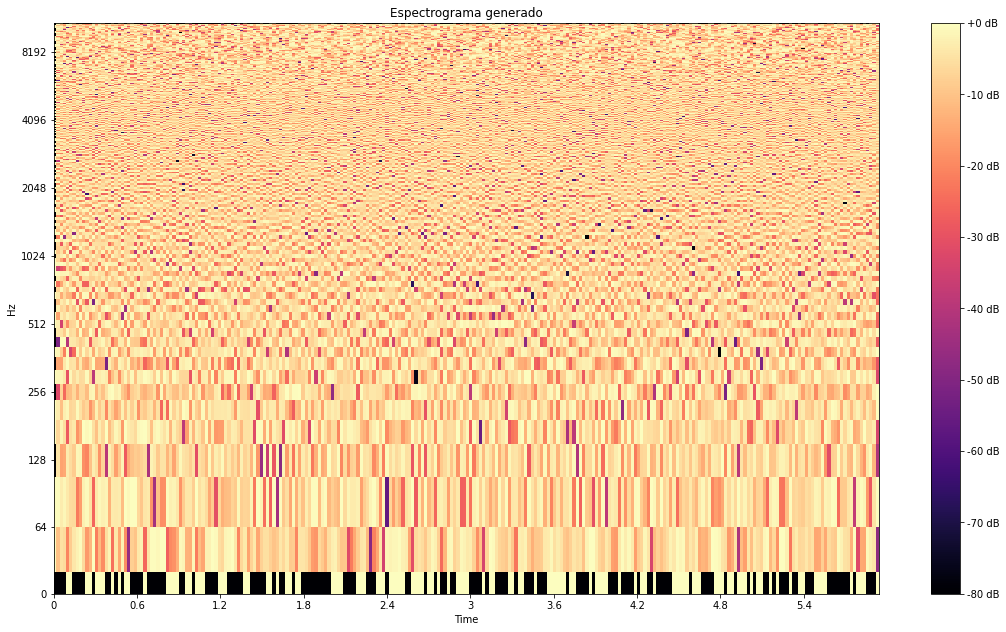

In [ ]:
#Espectro generado amplitud
os.chdir(r'/content/drive/My Drive/Denoising 5 - Labo de acústica/Drive/samples/generated')
original, sr = lb.load('28.wav', sr=22050)

S_original = np.angle(lb.stft(original, n_fft=512, hop_length=256))

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
img = librosa.display.specshow(lb.amplitude_to_db(S_original,ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Espectrograma generado')
fig.colorbar(img, ax=ax, format="%+2.0f dB")